# EDA and Ensemble Modeling

This was one of my first Kaggle Competitions. I was interested in implementing Ensemble of algorithms, and thanks for this competition since it provided a great way to practice and learn more about machine learning and proper cross validation techniques.
Huge Thanks to Ambrosm's [notebook](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense) for providing his code and sharing one of the best discussion notebooks I've seen. His code and guidence helped me to deepen my understading and learn about Ensemble modeling. I've explored and built on top of his work, so big shout out to Ambrosm. 


Here's the competetion and datasets used in this notebook.([Playground Series - Season 3, Episode 23](https://www.kaggle.com/competitions/playground-series-s3e23/): Binary Classification with a Software Defects Dataset)

This notebook shows
- simple EDA
- proper cross-validation
- preprocessing of the data for various classifiers
- tuning the most important hyperparameters of models
- utilization of ensemble to show how it performs better than any single model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



np.set_printoptions(linewidth=195, edgeitems=5)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading the data

In [2]:
result_list = []
train = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv', index_col='id')
with pd.option_context("display.min_rows", 6):
    display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

There are 101763 rows of data, which is plenty. There are no categorical variables, and no null values too. This is great, since we don't have to do a lot of data cleaning.

In [4]:
# check for duplicates

train.duplicated().sum()

0

No duplicates either! Awesome.

In [5]:
train.defects.value_counts(normalize=True)

defects
False    0.773356
True     0.226644
Name: proportion, dtype: float64

We can see that this dataset is unbalanced. At first, I thought of using SMOTE to synthetically upsample minority class, however, we have more than 100,000+ rows of data and we can utilize `StratifiedKFold` for cross-validation, which will conserve the ratio of target classes in each fold, thus, increasing confidence in our models.

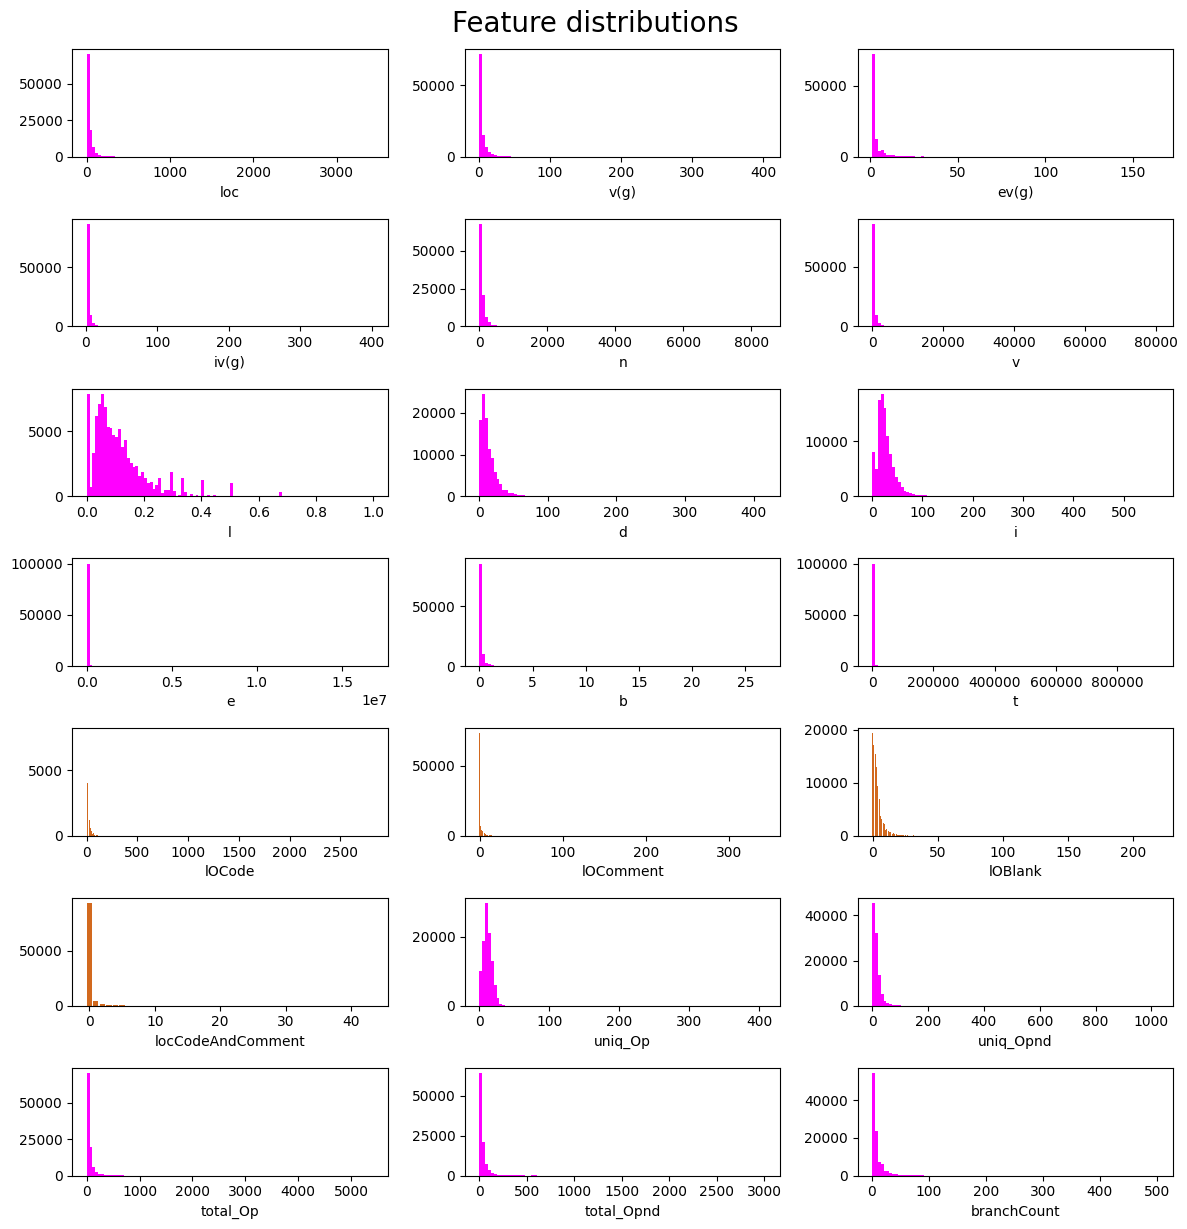

In [6]:
# Check distribution of each variable

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    if train[col].dtype == float:
        ax.hist(train[col], bins=100, color='magenta')
    else: #int
        vc = train[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

All of the variables are highly skewed, which indicates the need for log-transformation. Bunch of models would prefer if we log transform; we can implement log transformation in FuctionTransform(np.log1p) inside of `make_pipeline` function for models that require normally distributed variables. 

# Cross-validation

Defind a cross validation model to return accuracy and prediction lists.

In [7]:
def cross_val(model, label):
    """Cross-validate the model with a StratifiedKFold
    
    The cross-validation score is printed and added to the global result_list"""
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=1)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((auc, label, execution_time))
#     plt.figure(figsize=(6, 2))
#     plt.hist(oof, bins=200, density=True)
#     plt.show()
    return auc, oof
    

In [8]:
def plot_score_list(label, parameter, xscale='linear'):
    """Show a scatterplot of the scores in the global variable score_list"""
    plt.figure(figsize=(6, 3))
    plt.scatter([p for p, s in score_list],
                [s for p, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f'{parameter}{" (log-scale)" if xscale == "log" else ""}')
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

# Models
## LogisticRegression

Good to know:
- LogisticRegression are usually used in a pipeline after a StandardScaler.
- The documentation says for the algorithm: Prefer dual=False when n_samples > n_features.
- Regularization is controlled by C (low C = high regularization).
- For logistic regression, `solver='newton-cholesky'` is the fastest solver for the given dataset.
- For our dataset, LogisticRegression gives good scores with `class_weight='balanced`. All predicted probabilities will be too high, but this doesn't hurt the auc score.

The plots show that the hyperparameter `C` does matter. As @Ambrosm pointed out, "You'll rarely get good results without tuning `C`".

# AUC 0.78917   time=0:00:10   Poly-LogisticRegression C=0.01
# AUC 0.78947   time=0:00:11   Poly-LogisticRegression C=0.024
# AUC 0.78964   time=0:00:10   Poly-LogisticRegression C=0.056
# AUC 0.78972   time=0:00:10   Poly-LogisticRegression C=0.13
# AUC 0.78970   time=0:00:10   Poly-LogisticRegression C=0.32
# AUC 0.78955   time=0:00:09   Poly-LogisticRegression C=0.75
# AUC 0.78941   time=0:00:10   Poly-LogisticRegression C=1.8
# AUC 0.78923   time=0:00:10   Poly-LogisticRegression C=4.2
# AUC 0.78908   time=0:00:10   Poly-LogisticRegression C=10


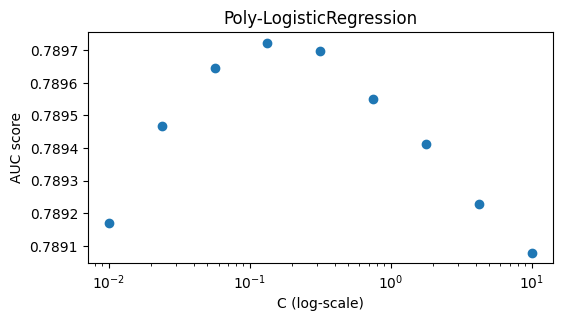

In [9]:
# LogisticRegression
score_list = []
for C in np.logspace(-2, 1, 9):
    auc, oof = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  PolynomialFeatures(2, include_bias=False),
                                  StandardScaler(),
                                  LogisticRegression(dual=False, C=C,
                                                     class_weight='balanced',
                                                     max_iter=1500,
                                                     random_state=1,
                                                     solver='newton-cholesky')),
                    f'Poly-LogisticRegression {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Poly-LogisticRegression', 'C', 'log')


Looks like C=0.1 would be like a good value

# Kernel Model

I haven't personally used Kernel Models before, so I learned a ton from @Ambrosm's notebook. Here's what he has to say about it:

**Kernel methods** are somewhat neglected on Kaggle, but they will play a role in this competition.

They have been developed based on two observations:

Linear machine learning models are limited because most machine learning tasks require a nonlinear solution.
Linear machine learning algorithms typically only apply linear operations in a vector space (vector addition, multiplication by a scalar, and scalar products) to the training and test data.
The math behind kernel methods takes some time to digest, but the main idea is that the data is mapped nonlinearly into a higher-dimensional vector space, and the linear classifier is applied to the higher-dimensional data. Because of the higher dimension, the linear classifier has more degrees of freedom to find a good decision surface. One can as well think of kernel methods as a form of automated feature engineering which generates nonlinear features for the linear classifier.

The drawback of kernel methods is their complexity: They work with a kernel matrix of size n_samples*n_samples, and calculating a 100000*100000 matrix for a 100000-row dataset takes too much time and memory. This is where kernel approximation enters the scene. Kernel approximation has almost the same benefits as the full kernel method, but at lower cost.

The following notebook cell cross-validates a linear classifier (logistic regression) with kernel approximation (Nyström approximation). Notice how the pipeline steps match the insight gained from EDA:

We start with a log transformation because our EDA has shown the right-skewed nonnegative feature distributions.
We then apply the Nyström approximation because we know that the dataset is too large to compute the full kernel matrix.
TLDR: The pipeline is the same as before, except that we have replaced PolynomialFeatures by Nystroem, and the score is substantially better.

# AUC 0.79103   time=0:00:19   Nyström-LogisticRegression n_components=400 C=0.001
# AUC 0.79108   time=0:00:18   Nyström-LogisticRegression n_components=400 C=0.0013
# AUC 0.79111   time=0:00:19   Nyström-LogisticRegression n_components=400 C=0.0018
# AUC 0.79112   time=0:00:18   Nyström-LogisticRegression n_components=400 C=0.0024
# AUC 0.79111   time=0:00:19   Nyström-LogisticRegression n_components=400 C=0.0032
# AUC 0.79110   time=0:00:18   Nyström-LogisticRegression n_components=400 C=0.0042
# AUC 0.79107   time=0:00:18   Nyström-LogisticRegression n_components=400 C=0.0056
# AUC 0.79104   time=0:00:19   Nyström-LogisticRegression n_components=400 C=0.0075
# AUC 0.79098   time=0:00:18   Nyström-LogisticRegression n_components=400 C=0.01


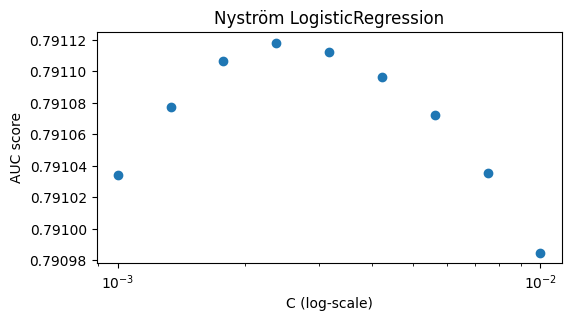

In [10]:
# Kernel approximation for logistic regression
score_list = []
n_components = 400
for C in np.logspace(-3, -2, 9):
    auc, oof = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  Nystroem(n_components=n_components, random_state=10), # gamma=1/21
                                  StandardScaler(),
                                  LogisticRegression(dual=False, C=C,
                                                     class_weight='balanced',
                                                     max_iter=1500,
                                                     random_state=1,
                                                     solver='newton-cholesky')),
                    f'Nyström-LogisticRegression {n_components=} {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Nyström LogisticRegression', 'C', 'log')


## ExtraTreesClassifier

One of the most important hyperparameters in ETClassifier is min_samples_leaf. Let's see which value gives use the best auc score.
- Setting max_features to 1.0 usually gives better auc scores than the default of max_features='sqrt', but slows down the training process.

# AUC 0.78647   time=0:02:04   ET min_samples_leaf=10
# AUC 0.78937   time=0:01:52   ET min_samples_leaf=20
# AUC 0.79123   time=0:01:30   ET min_samples_leaf=50
# AUC 0.79136   time=0:01:19   ET min_samples_leaf=100
# AUC 0.79116   time=0:01:13   ET min_samples_leaf=150


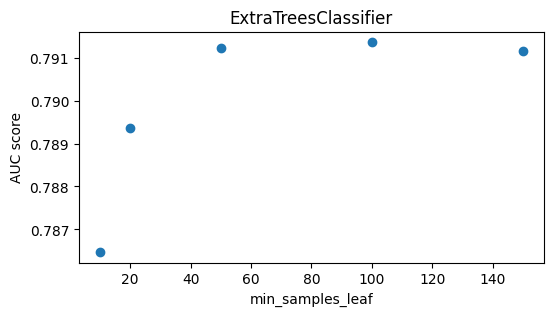

In [11]:
# ExtraTreesClassifier
score_list = []
for min_samples_leaf in [10, 20, 50, 100, 150]:
    auc, oof = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  ExtraTreesClassifier(n_estimators=100,
                                         min_samples_leaf=min_samples_leaf,
                                         max_features=1.0,
                                         random_state=1)),
                    f"ET {min_samples_leaf=}")
    score_list.append((min_samples_leaf, auc))
plot_score_list('ExtraTreesClassifier', 'min_samples_leaf')


The plot shows how the ExtraTreesClassifier scores depend on the hyperparameter `min_samples_leaf`. A value of 100 seems to be the optimum.

In [A comparison of hyperparameter settings for ExtraTreesClassifier](https://www.kaggle.com/competitions/playground-series-s3e23/discussion/446078), @broccolibeef shows that running ExtraTreesClassifier on a subset of the features improves the score.

I ran Grid Search to find the best parameters, however, the auc score was higher from the parameters that I found by manually trying out different values for different parameters. In addition, it was also faster to test different values on one parameter seperately rather than running a Grid Search.


Let's also see what n_estimator value would be the best:

# AUC 0.79153   time=0:00:24   ET n_estimator=50
# AUC 0.79173   time=0:00:48   ET n_estimator=100
# AUC 0.79169   time=0:01:35   ET n_estimator=200
# AUC 0.79169   time=0:02:23   ET n_estimator=300


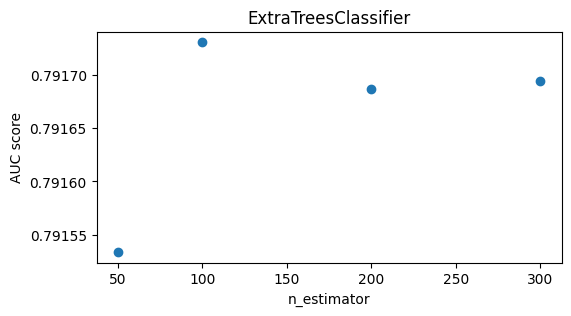

In [12]:
# ExtraTreesClassifier
score_list = []
for n_estimator in [50, 100, 200, 300]:
    auc, oof = cross_val(make_pipeline(ColumnTransformer([('drop', 'drop', 
                                              ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
                                               'branchCount', 'e', 'i', 'lOComment'])],
                                            remainder='passthrough'),
                          FunctionTransformer(np.log1p),
                          ExtraTreesClassifier(n_estimators=n_estimator,
                                               min_samples_leaf=100,
                                               max_features=1.0,
                                               random_state=1)),
                    f"ET {n_estimator=}")
    score_list.append((n_estimator, auc))
plot_score_list('ExtraTreesClassifier', 'n_estimator')


n_estimator = 100 is the best value.

Now, let's check the optimal 'depth' value.

# AUC 0.79174   time=0:00:47   ET depth=30
# AUC 0.79173   time=0:00:47   ET depth=50
# AUC 0.79173   time=0:00:47   ET depth=70


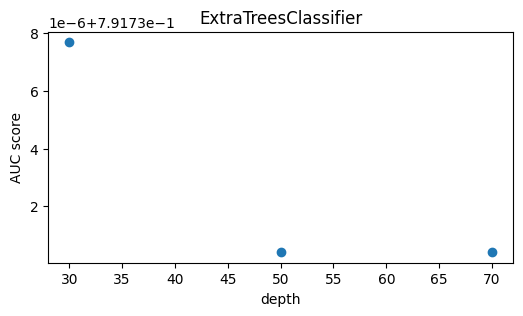

In [13]:
# ExtraTreesClassifier
score_list = []
for depth in [30, 50, 70]:
    auc, oof = cross_val(make_pipeline(ColumnTransformer([('drop', 'drop', 
                                              ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
                                               'branchCount', 'e', 'i', 'lOComment'])],
                                            remainder='passthrough'),
                          FunctionTransformer(np.log1p),
                          ExtraTreesClassifier(n_estimators=100,
                                               min_samples_leaf=100,
                                               max_features=1.0,
                                               max_depth = depth,
                                               random_state=1)),
                    f"ET {depth=}")
    score_list.append((depth, auc))
plot_score_list('ExtraTreesClassifier', 'depth')


Find the best split value

# AUC 0.79173   time=0:00:47   ET split=10
# AUC 0.79173   time=0:00:47   ET split=50
# AUC 0.79173   time=0:00:47   ET split=100
# AUC 0.79173   time=0:00:47   ET split=200
# AUC 0.79165   time=0:00:46   ET split=300


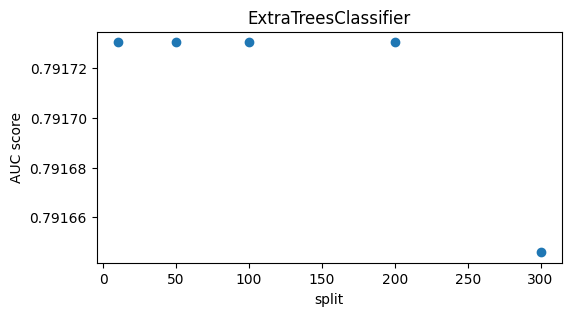

In [14]:
# ExtraTreesClassifier
score_list = []
for split in [10, 50, 100, 200, 300]:
    auc, oof = cross_val(make_pipeline(ColumnTransformer([('drop', 'drop', 
                                              ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
                                               'branchCount', 'e', 'i', 'lOComment'])],
                                            remainder='passthrough'),
                          FunctionTransformer(np.log1p),
                          ExtraTreesClassifier(n_estimators=100,
                                               min_samples_leaf=100,
                                               max_features=1.0,
                                               min_samples_split=split, 
                                               random_state=1)),
                    f"ET {split=}")
    score_list.append((split, auc))
plot_score_list('ExtraTreesClassifier', 'split')


## RandomForestClassifier

Good to know:
- The most important hyperparameter of a random forest is min_samples_leaf.
  - High min_samples_leaf: Estimator is fast, but underfits.
  - Low min_samples_leaf: Estimator is slow and overfits.
- Setting max_features to 1.0 usually gives better auc scores than the default of max_features='sqrt', but slows down the training process.

# AUC 0.79057   time=0:04:41   RF min_samples_leaf=100
# AUC 0.79107   time=0:04:17   RF min_samples_leaf=150
# AUC 0.79104   time=0:04:00   RF min_samples_leaf=200
# AUC 0.79091   time=0:03:47   RF min_samples_leaf=250
# AUC 0.79074   time=0:03:37   RF min_samples_leaf=300


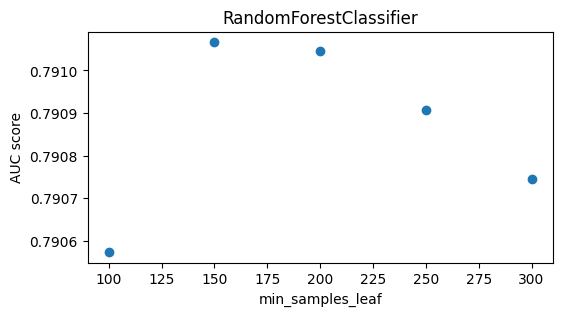

In [15]:
# RandomForestClassifier
score_list = []
for min_samples_leaf in [100, 150, 200, 250, 300]:
    auc, oof = cross_val(RandomForestClassifier(n_estimators=100,
                                           min_samples_leaf=min_samples_leaf,
                                           max_features=1.0,
                                           random_state=1),
                    f"RF {min_samples_leaf=}")
    score_list.append((min_samples_leaf, auc))
plot_score_list('RandomForestClassifier', 'min_samples_leaf')

# AUC 0.78969   time=0:05:33   RF min_samples_leaf=50
# AUC 0.79057   time=0:04:50   RF min_samples_leaf=100
# AUC 0.79104   time=0:04:12   RF min_samples_leaf=200
# AUC 0.79074   time=0:03:43   RF min_samples_leaf=300
# AUC 0.79058   time=0:03:29   RF min_samples_leaf=400

The plot shows how the random forest scores depend on `min_samples_leaf`. A value of 150 to 200 seems to be the optimum.

## HistGradientBoostingClassifier

Good to know:
- If the sample size is larger than 10000, HistGradientBoostingClassifier uses 10 % of its training data as an internal validation set for early stopping. This means that we don't need to tune `max_iter`.

# AUC 0.79006   time=0:00:11   rate rate=0.01
# AUC 0.79105   time=0:00:08   rate rate=0.05
# AUC 0.79060   time=0:00:04   rate rate=0.1
# AUC 0.78921   time=0:00:03   rate rate=0.2


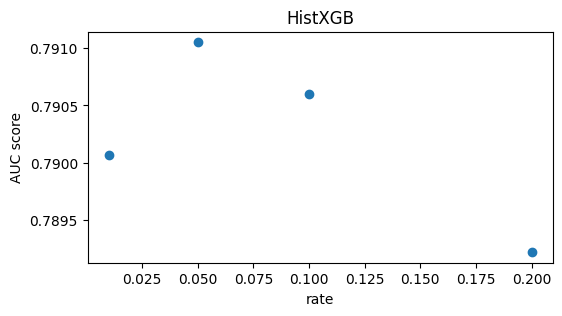

In [16]:
# HistGradientBoostingClassifier
score_list, oof_list = [], []
for rate in  [0.01, 0.05, 0.1, 0.2]:
    auc, oof = cross_val(HistGradientBoostingClassifier(random_state=1, max_bins=250,
                                      learning_rate = rate, 
#                                        max_leaf_nodes = 65,
                                           max_leaf_nodes = 65,
                                       l2_regularization= 1),
                    f"rate {rate=}")
    score_list.append((rate, auc))
    oof_list.append((rate, oof))
plot_score_list('HistXGB', 'rate')

Learning rate at 0.05 is the best value

# AUC 0.79072   time=0:00:08   bins bins=50
# AUC 0.79095   time=0:00:09   bins bins=100
# AUC 0.79091   time=0:00:08   bins bins=150
# AUC 0.79105   time=0:00:09   bins bins=250


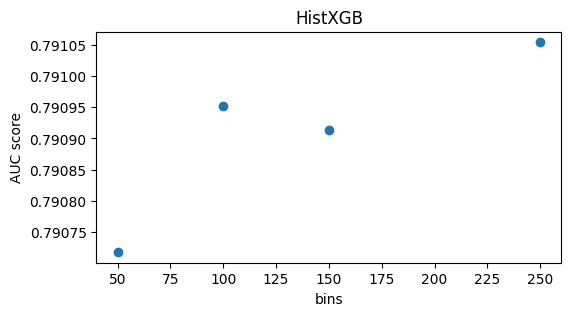

In [17]:
score_list, oof_list = [], []
for bins in  [50, 100, 150, 250]:
    auc, oof = cross_val(HistGradientBoostingClassifier(random_state=1, max_bins=bins,
                                      learning_rate = 0.05, 
#                                        max_leaf_nodes = 65,
                                           max_leaf_nodes = 65,
                                       l2_regularization= 1),
                    f"bins {bins=}")
    score_list.append((bins, auc))
    oof_list.append((bins, oof))
plot_score_list('HistXGB', 'bins')

# AUC 0.79127   time=0:00:04   nodes nodes=10
# AUC 0.79157   time=0:00:06   nodes nodes=20
# AUC 0.79151   time=0:00:06   nodes nodes=30


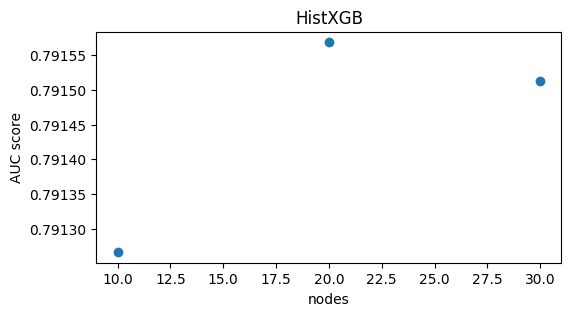

In [18]:
score_list, oof_list = [], []
for nodes in  [10, 20, 30]:
    auc, oof = cross_val(HistGradientBoostingClassifier(random_state=1,
                                      learning_rate = 0.05, 
#                                        max_leaf_nodes = 65,
                                           max_leaf_nodes = nodes,
                                       l2_regularization= 1),
                    f"nodes {nodes=}")
    score_list.append((nodes, auc))
    oof_list.append((nodes, oof))
plot_score_list('HistXGB', 'nodes')

# AUC 0.79143   time=0:00:05   l2_reg reg=0
# AUC 0.79144   time=0:00:05   l2_reg reg=0.1
# AUC 0.79157   time=0:00:05   l2_reg reg=1


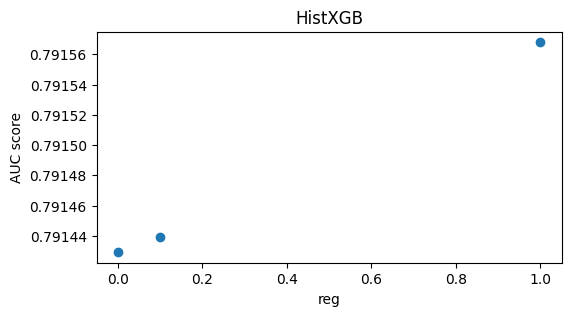

In [19]:
score_list, oof_list = [], []
for reg in  [0, 0.1, 1]:
    auc, oof = cross_val(HistGradientBoostingClassifier(random_state=1,
                                      learning_rate = 0.05, 
#                                        max_leaf_nodes = 65,
                                           max_leaf_nodes = 20,
                                       l2_regularization= reg),
                    f"l2_reg {reg=}")
    score_list.append((reg, auc))
    oof_list.append((reg, oof))
plot_score_list('HistXGB', 'reg')

# AUC 0.79166   time=0:00:06   min_s_leaf min_s_leaf=30
# AUC 0.79160   time=0:00:05   min_s_leaf min_s_leaf=50
# AUC 0.79182   time=0:00:05   min_s_leaf min_s_leaf=70


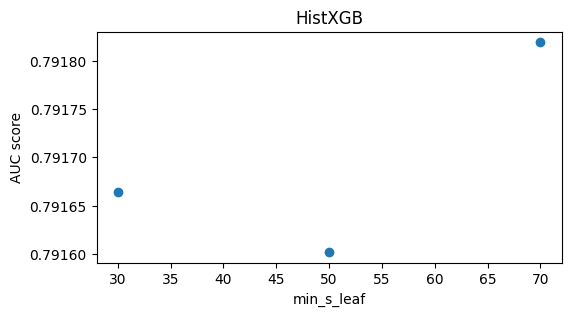

In [20]:
score_list, oof_list = [], []
for min_s_leaf in  [30, 50, 70]:
    auc, oof = cross_val(HistGradientBoostingClassifier(random_state=1,
                                      learning_rate = 0.05, 
#                                        max_leaf_nodes = 65,
                                           max_leaf_nodes = 20,
                                       l2_regularization= 1,
                                                       min_samples_leaf=min_s_leaf),
                    f"min_s_leaf {min_s_leaf=}")
    score_list.append((min_s_leaf, auc))
    oof_list.append((min_s_leaf, oof))
plot_score_list('HistXGB', 'min_s_leaf')

# XGB Classifier

## Best XGB parameters

# AUC 0.78878   time=0:00:14   rate rate=0.01
# AUC 0.79146   time=0:00:15   rate rate=0.05
# AUC 0.79177   time=0:00:14   rate rate=0.1
# AUC 0.79070   time=0:00:15   rate rate=0.2
# AUC 0.78936   time=0:00:14   rate rate=0.3


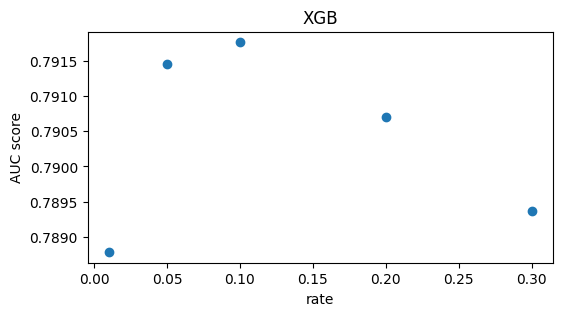

In [21]:
score_list, oof_list = [], []
for rate in  [0.01, 0.05, 0.1, 0.2, 0.3]:
    auc, oof = cross_val(XGBClassifier(
       colsample_bytree = 0.7, learning_rate = rate, 
                           max_depth = 4, n_estimators = 100, 
                          subsample = 0.8, random_state=1, 
                          objective='binary:logistic'
        ),
                    f"rate {rate=}")
    score_list.append((rate, auc))
    oof_list.append((rate, oof))
plot_score_list('XGB', 'rate')

# AUC 0.79177   time=0:00:15   n_estimator n_estimator=100
# AUC 0.79151   time=0:00:29   n_estimator n_estimator=200
# AUC 0.79114   time=0:00:43   n_estimator n_estimator=300
# AUC 0.79064   time=0:00:58   n_estimator n_estimator=400
# AUC 0.79007   time=0:01:12   n_estimator n_estimator=500
# AUC 0.78939   time=0:01:27   n_estimator n_estimator=600
# AUC 0.78885   time=0:01:40   n_estimator n_estimator=700


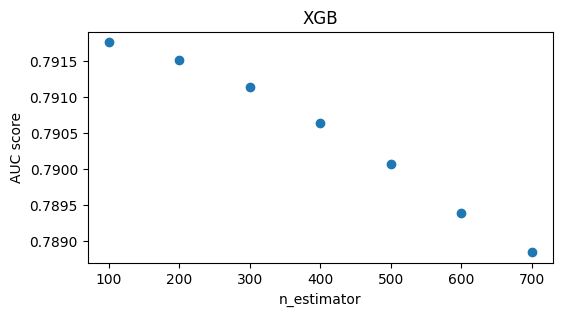

In [22]:
score_list, oof_list = [], []
for n_estimator in range(100, 800, 100):
    auc, oof = cross_val(XGBClassifier(
       colsample_bytree = 0.7, learning_rate = 0.1, 
                           max_depth = 4, n_estimators = n_estimator, 
                          subsample = 0.8, random_state=1, 
                          objective='binary:logistic'
        ),
                    f"n_estimator {n_estimator=}")
    score_list.append((n_estimator, auc))
    oof_list.append((n_estimator, oof))
plot_score_list('XGB', 'n_estimator')

# AUC 0.79165   time=0:00:14   depth depth=3
# AUC 0.79189   time=0:00:18   depth depth=4


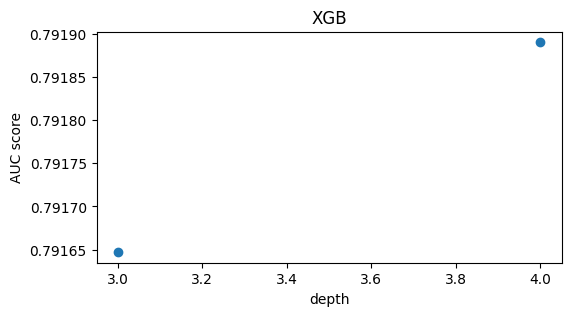

In [23]:
score_list, oof_list = [], []
for depth in [3,4]:
    auc, oof = cross_val(XGBClassifier(
#        colsample_bytree = 0.7,
        learning_rate = 0.1, 
                           max_depth = depth, n_estimators = 100, 
                          subsample = 0.8, random_state=1, 
                          objective='binary:logistic'
        ),
                    f"depth {depth=}")
    score_list.append((depth, auc))
    oof_list.append((depth, oof))
plot_score_list('XGB', 'depth')

# AUC 0.79184   time=0:00:20   samplesample=0.5
# AUC 0.79198   time=0:00:20   samplesample=0.6
# AUC 0.79189   time=0:00:18   samplesample=0.7
# AUC 0.79189   time=0:00:19   samplesample=0.8


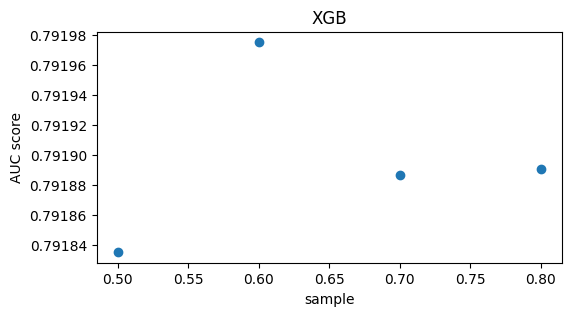

In [24]:
score_list, oof_list = [], []
for sample in [0.5, 0.6, 0.7, 0.8]:
    auc, oof = cross_val(XGBClassifier(
#        colsample_bytree = 0.7,
        learning_rate = 0.1, 
                           max_depth = 4, n_estimators = 100, 
                          subsample = sample, random_state=1, 
                          objective='binary:logistic'
        ),
                    f"sample{sample=}")
    score_list.append((sample, auc))
    oof_list.append((sample, oof))
plot_score_list('XGB', 'sample')

# CatBoost Classifier

# AUC 0.79179   time=0:00:30   iteration iteration=400
# AUC 0.79191   time=0:00:37   iteration iteration=500
# AUC 0.79181   time=0:00:44   iteration iteration=600
# AUC 0.79175   time=0:00:51   iteration iteration=700
# AUC 0.79152   time=0:00:58   iteration iteration=800
# AUC 0.79136   time=0:01:05   iteration iteration=900


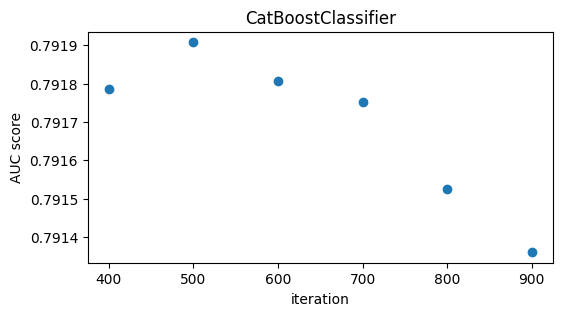

In [25]:
score_list, oof_list = [], []
for iteration in  range(400, 1000, 100):
    auc, oof = cross_val(CatBoostClassifier(
        iterations=iteration, 
        learning_rate=0.05,
        random_state= 1, 
        silent=True
        #loss_function='CrossEntropy'
        ),
                    f"iteration {iteration=}")
    score_list.append((iteration, auc))
    oof_list.append((iteration, oof))
plot_score_list('CatBoostClassifier', 'iteration')

# AUC 0.79070   time=0:00:38   rate rate=0.01
# AUC 0.79191   time=0:00:37   rate rate=0.05
# AUC 0.79062   time=0:00:37   rate rate=0.1
# AUC 0.78866   time=0:00:36   rate rate=0.15
# AUC 0.78569   time=0:00:37   rate rate=0.2


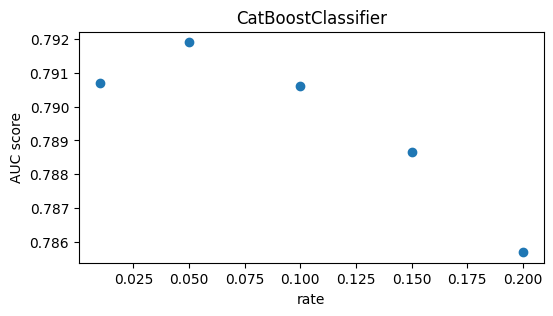

In [26]:
score_list, oof_list = [], []
for rate in [0.01, 0.05, 0.1, 0.15, 0.2]:
    auc, oof = cross_val(CatBoostClassifier(
        iterations=500, 
        learning_rate=rate,
        random_state= 1, 
        silent=True
        #loss_function='CrossEntropy'
        ),
                    f"rate {rate=}")
    score_list.append((rate, auc))
    oof_list.append((rate, oof))
plot_score_list('CatBoostClassifier', 'rate')

# LGBMC Classifier

# AUC 0.78869   time=0:00:09   learning_rate rate=0.01
# AUC 0.79063   time=0:00:09   learning_rate rate=0.05
# AUC 0.79145   time=0:00:09   learning_rate rate=0.1
# AUC 0.79125   time=0:00:08   learning_rate rate=0.15
# AUC 0.79143   time=0:00:08   learning_rate rate=0.2
# AUC 0.79016   time=0:00:09   learning_rate rate=0.25
# AUC 0.78955   time=0:00:07   learning_rate rate=0.3


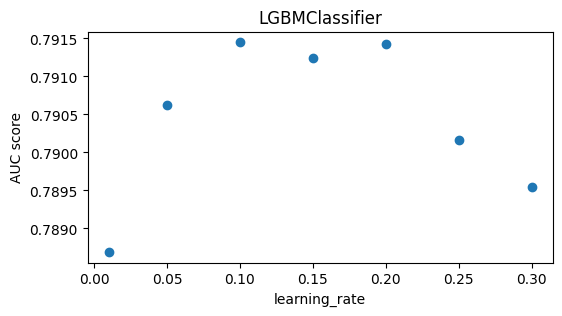

In [27]:
score_list, oof_list = [], []
for rate in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    auc, oof = cross_val(
        LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=rate)
        ,
                    f"learning_rate {rate=}")
    score_list.append((rate, auc))
    oof_list.append((rate, oof))
plot_score_list('LGBMClassifier', 'learning_rate')


# AUC 0.79145   time=0:00:09   n_estimators n_estimator=100
# AUC 0.79172   time=0:00:27   n_estimators n_estimator=200
# AUC 0.79167   time=0:00:52   n_estimators n_estimator=300
# AUC 0.79145   time=0:01:23   n_estimators n_estimator=400


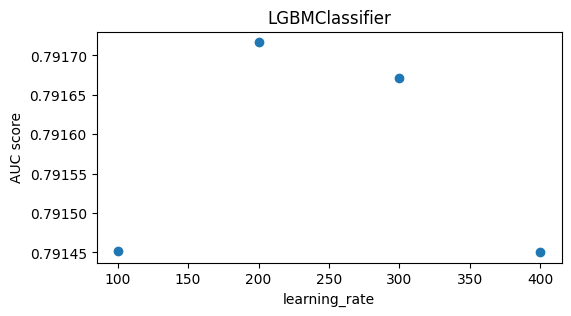

In [28]:
score_list, oof_list = [], []
for n_estimator in range(100,500, 100):
    auc, oof = cross_val(
        LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=n_estimator)
        ,
                    f"n_estimators {n_estimator=}")
    score_list.append((n_estimator, auc))
    oof_list.append((n_estimator, oof))
plot_score_list('LGBMClassifier', 'learning_rate')


# AUC 0.79172   time=0:00:27   n_leaves n_leaf=31
# AUC 0.79086   time=0:00:30   n_leaves n_leaf=50
# AUC 0.78991   time=0:00:37   n_leaves n_leaf=100


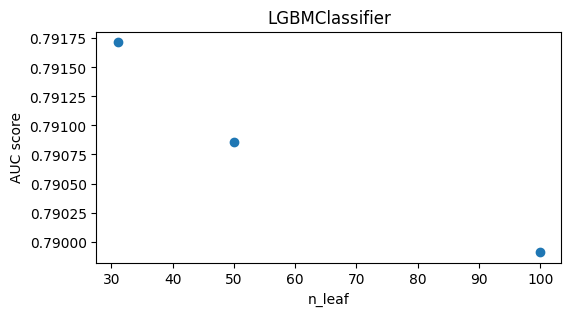

In [29]:
score_list, oof_list = [], []
for n_leaf in [31, 50, 100]:
    auc, oof = cross_val(
        LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=200, num_leaves=n_leaf)
        ,
                    f"n_leaves {n_leaf=}")
    score_list.append((n_leaf, auc))
    oof_list.append((n_leaf, oof))
plot_score_list('LGBMClassifier', 'n_leaf')


# AUC 0.79160   time=0:00:28   n_leaves depth=5
# AUC 0.79160   time=0:00:27   n_leaves depth=10
# AUC 0.79172   time=0:00:27   n_leaves depth=20
# AUC 0.79172   time=0:00:27   n_leaves depth=30
# AUC 0.79172   time=0:00:27   n_leaves depth=50


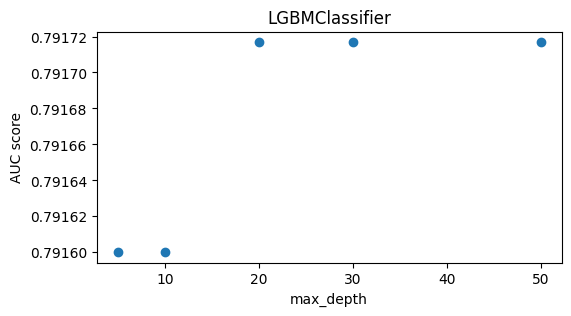

In [30]:
score_list, oof_list = [], []
for depth in [5, 10, 20, 30, 50]:
    auc, oof = cross_val(
        LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=200, max_depth = depth)
        ,
                    f"n_leaves {depth=}")
    score_list.append((depth, auc))
    oof_list.append((depth, oof))
plot_score_list('LGBMClassifier', 'max_depth')

# AUC 0.79152   time=0:00:26   min_gain min_gain=1
# AUC 0.79174   time=0:00:24   min_gain min_gain=5
# AUC 0.79115   time=0:00:18   min_gain min_gain=10
# AUC 0.79031   time=0:00:14   min_gain min_gain=20


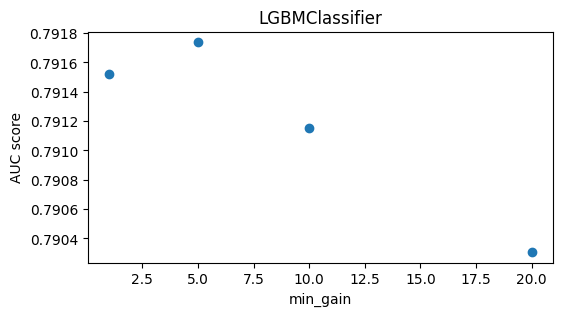

In [31]:
score_list, oof_list = [], []
for min_gain in [1, 5, 10, 20]:
    auc, oof = cross_val(
        LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=200, max_depth = 30, min_split_gain=min_gain)
        ,
                    f"min_gain {min_gain=}")
    score_list.append((min_gain, auc))
    oof_list.append((min_gain, oof))
plot_score_list('LGBMClassifier', 'min_gain')

## Gradient Boost

# AUC 0.78750   time=0:01:36   learning_rate rate=0.01
# AUC 0.79102   time=0:01:37   learning_rate rate=0.1
# AUC 0.79099   time=0:01:39   learning_rate rate=0.2
# AUC 0.79053   time=0:01:36   learning_rate rate=0.3


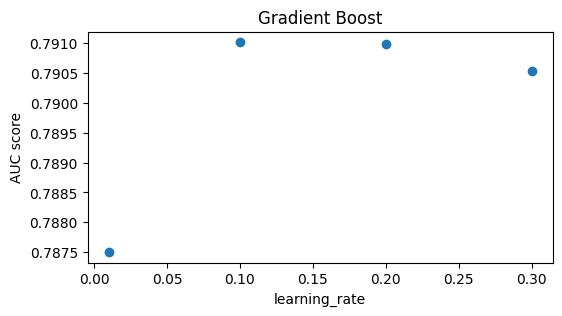

In [32]:
score_list, oof_list = [], []
for rate in [0.01, 0.1, 0.2, 0.3]:
    auc, oof = cross_val(
         GradientBoostingClassifier(random_state = 1, learning_rate=rate, n_estimators=100),
                    f"learning_rate {rate=}")
    score_list.append((rate, auc))
    oof_list.append((rate, oof))
plot_score_list('Gradient Boost', 'learning_rate')


After running many ensembles with GBClassifier, I found that it actually worsened the results.

# Ensemble

My final model consists of 6 models:`HistGradientBoostingClassifier`, `LGBClassifier`, `CatBoost`, `ETCLassifier`, `XGB` and logistic regression with kernel approximation: 

In [33]:
auc_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
#     ('hgb', HistGradientBoostingClassifier(random_state=1, max_bins=250,
#                                       learning_rate = 0.1, 
# #                                        max_leaf_nodes = 65,
#                                            max_leaf_nodes = 50,
#                                        l2_regularization= 1)),
     ('hgb', HistGradientBoostingClassifier(random_state=1,
                                      learning_rate = 0.05, 
                                           max_leaf_nodes = 20,
                                       l2_regularization= 1,
                                                       min_samples_leaf=70)),
    
    # higher number of max leaf nodes results in better score optimal 65
    # increasing learning rate leads to lower accuracy keep it at 0.1 or 0.2
    # 
    # 
    
#     'l2_regularization': 0.1, 'learning_rate': 0.1, 
#     'max_bins': 100, 'max_depth': 10, 'max_leaf_nodes': 15, 
#     'min_samples_leaf': 150
    ('cat', CatBoostClassifier(
                                iterations=500, 
                                learning_rate=0.05,
                                random_state= 1, 
                                silent=True
                                #loss_function='CrossEntropy'
                                )),
#     ('knn', make_pipeline(FunctionTransformer(np.log1p),
#                                   StandardScaler(),
#                                   KNeighborsClassifier(n_neighbors=400,
#                                                        weights='distance'))),
#     ('hgb', HistGradientBoostingClassifier(l2_regularization = 0.1, learning_rate= 0.1, 
#                                            max_bins = 100, max_depth= 10, 
#                                            max_leaf_nodes=15, min_samples_leaf = 150)),
#     ('lgmbc_dart',  LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
#                       n_estimators=200)),
       ('lgmbc_dart',  LGBMClassifier( random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=200, max_depth = 30, min_split_gain=5)),

#     ('gb',  GradientBoostingClassifier(random_state = 1, learning_rate=0.1, n_estimators=100)),
#     ('xgb', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, objective='binary:logistic', subsample=0.5, random_state=1)),
     ('xgb', XGBClassifier( learning_rate = 0.1, 
                           max_depth = 4, n_estimators = 100, 
                          subsample = 0.6, random_state=1, 
                          objective='binary:logistic')),
    ('et', make_pipeline(ColumnTransformer([('drop', 'drop', 
                                              ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
                                               'branchCount', 'e', 'i', 'lOComment'])],
                                            remainder='passthrough'),
                          FunctionTransformer(np.log1p),
                          ExtraTreesClassifier(n_estimators=100,
                                               min_samples_leaf=100,
                                               max_features=1.0,
                                               random_state=1))),
#      ('rf', make_pipeline(ColumnTransformer([('drop', 'drop', 
#                                               ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
#                                                'branchCount', 'e', 'i', 'lOComment'])],
#                                             remainder='passthrough'),
#                           FunctionTransformer(np.log1p),
#                       RandomForestClassifier(n_estimators=500,
#                                            min_samples_leaf=150,
#                                            max_features=1.0,
#                                            random_state=1))),
#                               ExtraTreesClassifier(n_estimators=200,
#                                                min_samples_leaf=100,
#                                                min_samples_split=100,
#                                                max_features=1.0,
#                                                bootstrap=True,
#                                                max_depth=10,
#                                                random_state=1))),
    ('ny', make_pipeline(FunctionTransformer(np.log1p),
                                      Nystroem(n_components=400, random_state=1),
                                      StandardScaler(),
                                      LogisticRegression(dual=False, C=0.0032,
                                                         max_iter=1500,
                                                         random_state=1)))
#     ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
#     ('lda', LinearDiscriminantAnalysis()),
#     ('gnb', GaussianNB()),
#     ('bnb', BernoulliNB()),
#     ('knn', KNeighborsClassifier()),
#     ('rf', RandomForestClassifier(random_state = seed)),
#     ('et', ExtraTreesClassifier(random_state = seed)),
#     ('xgb', XGBClassifier(random_state = seed)),
#     ('lgb', LGBMClassifier(random_state = seed)),
#     ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
#     ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
#     ('gb', GradientBoostingClassifier(random_state = seed)),
#     ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    auc_list[label], oof_list[label] = cross_val(
        model,
        label = label
    )

# AUC 0.79182   time=0:00:05   hgb
# AUC 0.79191   time=0:00:37   cat
# AUC 0.79174   time=0:00:24   lgmbc_dart
# AUC 0.79198   time=0:00:20   xgb
# AUC 0.79173   time=0:00:47   et
# AUC 0.79101   time=0:00:36   ny


# Notes on accuracy scores and utilization of different algorithms

- Adding RF to the ensemble didn't quite help.
- Adding CatBoost, increased my model by 0.007, which is was a big jump
- Hyper tuning HGB, ET, and XGB helped immensily with the prediction score on testing data

## Using RidgeClassifier to calculate the weights

Thanks to Iqbal Syah Akbar, for showing how to [use RidgleClassifier](https://www.kaggle.com/code/iqbalsyahakbar/ps3e23-binary-classification-for-beginners) to calculate the weights.

In [34]:
weights = RidgeClassifier(random_state = 1).fit(oof_list, train.defects).coef_[0]
pd.DataFrame(weights, index = list(oof_list), columns = ['weight per model'])


,weight per model
hgb,0.361973
cat,0.466550
lgmbc_dart,0.201569
xgb,0.152139
et,0.307145
ny,0.539877


Interesting to see that the best performing model in training dataset received the lowest weight, and the lowest performing model (Logistic Regression) received the highest weight.

In [35]:
ensemble = VotingClassifier(
#     [('hgb', HistGradientBoostingClassifier(random_state=1, max_bins=250, max_iter=150,
#                                       learning_rate = 0.1, 
#                                        max_leaf_nodes = 40,
#                                        l2_regularization= 1)),
      [('hgb', HistGradientBoostingClassifier(random_state=1,
                                      learning_rate = 0.05, 
                                           max_leaf_nodes = 20,
                                       l2_regularization= 1,
                                                       min_samples_leaf=70)),
    ('cat', CatBoostClassifier(
                                iterations=500, 
                                learning_rate=0.05,
                                random_state= 1, 
                                silent=True
                                #loss_function='CrossEntropy'
                                )),
#     ('hgb', HistGradientBoostingClassifier(l2_regularization = 0.1, learning_rate= 0.1, 
#                                            max_bins = 100, max_depth= 10, 
#                                            max_leaf_nodes=15, min_samples_leaf = 150)),
       ('lgmbc_dart',  LGBMClassifier(random_state = 1, boosting_type = 'dart', learning_rate=0.1,
                      n_estimators=200, min_split_gain=5)),
#      ('gb',  GradientBoostingClassifier(random_state = 1, learning_rate=0.1, n_estimators=100)),
    ('xgb', XGBClassifier(learning_rate = 0.1, 
                           max_depth = 4, n_estimators = 100, 
                          subsample = 0.6, random_state=1, 
                          objective='binary:logistic')),
     ('et', make_pipeline(ColumnTransformer([('drop', 'drop', 
                                              ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
                                               'branchCount', 'e', 'i', 'lOComment'])],
                                            remainder='passthrough'),
                          FunctionTransformer(np.log1p),
                          ExtraTreesClassifier(n_estimators=100,
                                               min_samples_leaf=100,
                                               max_features=1.0,
                                               random_state=1))),
#       ('rf', make_pipeline(ColumnTransformer([('drop', 'drop', 
#                                               ['iv(g)', 't', 'b', 'n', 'lOCode', 'v',
#                                                'branchCount', 'e', 'i', 'lOComment'])],
#                                             remainder='passthrough'),
#                           FunctionTransformer(np.log1p),
#                       RandomForestClassifier(n_estimators=500,
#                                            min_samples_leaf=150,
#                                            max_features=1.0,
#                                            random_state=1))),
#                       ExtraTreesClassifier(n_estimators=200,
#                                                min_samples_leaf=100,
#                                                min_samples_split=100,
#                                                max_features=1.0,
#                                                bootstrap=True,
#                                                max_depth=10,
#                                                random_state=1))),
     
     ('ny', make_pipeline(FunctionTransformer(np.log1p),
                                      Nystroem(n_components=400, random_state=1),
                                      StandardScaler(),
                                      LogisticRegression(dual=False, C=0.0032,
                                                         max_iter=1500,
                                                         random_state=1)))],
    voting='soft',
    weights=weights)
auc, oof = cross_val(ensemble, 'Ensemble(HGB+RF+LGBDart+XGB+ET+NY)')


# AUC 0.79272   time=0:02:54   Ensemble(HGB+RF+LGBDart+XGB+ET+NY)


In the end; the model above was my best one. AUC score on test data was 0.79356, and I got a 299 place out of 1702 teams, top 20% of all models.

In [36]:
%%time
ensemble.fit(train.iloc[:, :-1], train.defects)
y_pred = ensemble.predict_proba(test)[:, 1]
submission = pd.Series(y_pred, index=test.index, name='defects')
submission.to_csv('submission_ensemble_19_HGB_CAT_LGBMC_XGB_ETC_NA.csv')
# !head submission.csv

CPU times: user 2min 8s, sys: 6.94 s, total: 2min 15s
Wall time: 45.8 s
